# Applied Machine Learning - Exercise 1

Train a `sklearn.ensemble.RandomForestClassifier` that given a football player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

In [269]:
import pandas as pd                                     
import numpy as np                    

import matplotlib.pyplot as plt
from sklearn import metrics
import os                                         

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import seaborn as sns                                   # For pretty plots

In [270]:
data = pd.read_csv('data/players_cleaned_with_feature.csv')
data.head()

,playerShort,club,leagueCountry,birthday,position,yellowCards,redCards,victories,goals,meanIAT_yellowCards,...,meanExp_yellowReds,games,meanExp_redCards,ties,meanExp_yellowCards,height,defeats,meanIAT_yellowReds,weight,skin_color
0,aaron-hughes,Fulham FC,England,3598.0,Center Back,19,0,247,9,-0.034618,...,-0.001615,654,-0.001707,179,-0.040843,182.0,228,-0.001343,71.0,0.125
1,aaron-hunt,Werder Bremen,Germany,6090.0,Attacking Midfielder,42,1,141,62,-0.002753,...,-0.001535,336,-0.000623,73,-0.002366,183.0,122,-0.001376,73.0,0.125
2,aaron-lennon,Tottenham Hotspur,England,6314.0,Right Midfielder,11,0,200,31,-0.035463,...,-0.001610,412,-0.001702,97,-0.042534,165.0,115,-0.001340,63.0,0.250
3,aaron-ramsey,Arsenal FC,England,7664.0,Center Midfielder,31,1,150,39,-0.004654,...,-0.001747,260,-0.000554,42,-0.006586,178.0,68,-0.001357,76.0,0.000
4,abdelhamid-el-kaoutari,Montpellier HSC,France,7380.0,Center Back,8,2,41,1,-0.022667,...,0.010400,124,0.004019,40,-0.022177,180.0,43,0.009606,73.0,0.250


## Data treatment

### Skin color

In order to perform the classification, we need to determine how much label categories we want. We choose to separate the skin_color of the players in only two groups that we'll call white and black.   

In [271]:
data["skin_color"] = data["skin_color"].apply(lambda x: 0 if x <=0.5 else 1)
data.groupby(["skin_color"])["skin_color"].count()

skin_color
0    1203
1     230
Name: skin_color, dtype: int64

### Nan values

We still have some unknown height and weight values in our data, so we drop them

In [272]:
data = data.dropna()

### Numerization of string values

In order to use the the features with string values, we need to convert them to numerical values. We will just assign the same integer to every same values.

We start with the players position:

In [273]:
for feature in ["position","leagueCountry","club"]:
    num, labels = pd.factorize(data[feature])
    data[feature] = num

We don't need the names of the players, so we simply drop them

In [274]:
data = data.drop("playerShort", axis=1)

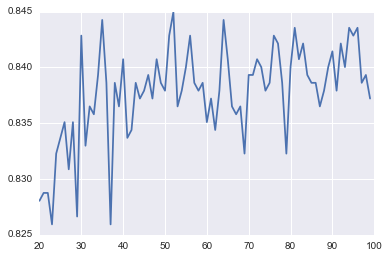

In [291]:
oob_test(data)

In [292]:
def oob_test(data):
    forest_label = data["skin_color"]
    forest_data = data.drop(["skin_color"], axis = 1)

    oob = []
    for i in range(30, 100, 1):
        forest = RandomForestClassifier(n_estimators = i, max_features=0.33, max_depth=20, n_jobs=-1, oob_score=True)
        forest.fit(forest_data, forest_label)
        oob.append(forest.oob_score_)

    plt.plot(range(30, 100, 1), oob, '-')

In [293]:
def display_feature_importance(forest, data, labels):
    importance = forest.feature_importances_    
    df_importance = pd.DataFrame([importance], columns = data.columns)
    n_col = len(data.columns)
    # graph
    fig, ax = plt.subplots()
    ax.bar(range(len(importance)), importance)
    ax.set_xticks(np.arange(0.5, n_col+0.5, 1))
    ax.set_xticklabels(df_importance.columns, rotation=90)

In [294]:
def split_data(data, labels, ratio=0.5):
    len_train = int(ratio*len(data))
    train_data = data.ix[:len_train,:]
    test_data = data.ix[len_train:,:]
    train_labels = labels.ix[:len_train]
    test_labels = labels.ix[len_train:]
    return train_data, test_data, train_labels, test_labels

In [295]:
def run_forest_importance(data):
    forest = RandomForestClassifier(n_estimators = 100, max_features="auto", max_depth=20, n_jobs=-1)
    forest_labels = data["skin_color"]
    forest_data = data.drop(["skin_color"], axis = 1)
    train_data, test_data, train_labels, test_labels = split_data(forest_data, forest_labels, 0.7)
    forest.fit(train_data, train_labels)
    display_feature_importance(forest, forest_data, forest_labels)
    return forest, train_data, train_labels, test_data, test_labels

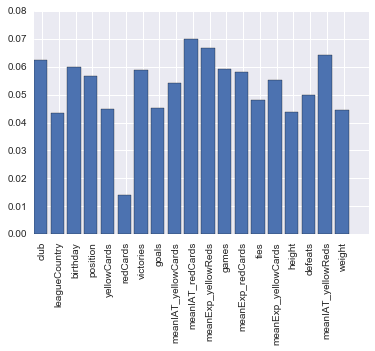

In [296]:
forest, train_dat, train_labels, test_data, test_labels = run_forest_importance(data)

In [297]:
test_pred = forest.predict(test_data)
metrics.accuracy_score(test_labels, test_pred)

0.86896551724137927

In [298]:
df_test_labels = test_labels.to_frame()
df_test_labels.index = range(0, len(df_test_labels))
df_test_labels.columns=["skin_color_labels"]
df_test_labels.groupby("skin_color_labels").size()/len(test_labels)*100.0

skin_color_labels
0    85.747126
1    14.252874
dtype: float64

In [299]:
df_pred = pd.Series(test_pred).to_frame()
df_pred.index = range(0, len(df_pred))
df_pred.columns=["skin_color_pred"]
df_pred.groupby("skin_color_pred").size()/len(test_labels)*100.0

skin_color_pred
0    98.850575
1     1.149425
dtype: float64

In [300]:
(test_labels - test_pred).to_frame().groupby("skin_color").size()/len(test_labels)*100.0

skin_color
0    86.896552
1    13.103448
dtype: float64

In [301]:
comparison = pd.concat([df_pred,df_test_labels],axis=1)
comparison[comparison["skin_color_pred"] == 1].groupby("skin_color_labels").size()

skin_color_labels
1    5
dtype: int64

In [302]:
comparison[comparison["skin_color_pred"] == 0].groupby("skin_color_labels").size()

skin_color_labels
0    373
1     57
dtype: int64

## Removing features

In [303]:
removed_features = ["birthday","victories","goals","ties","defeats"]
removed_features = ["club"]
new_data = data.drop(removed_features, axis=1)

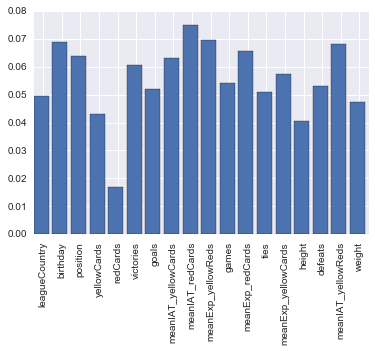

In [304]:
forest, train_dat, train_labels, test_data, test_labels = run_forest_importance(new_data)

In [305]:
test_pred = forest.predict(test_data)
metrics.accuracy_score(test_labels, test_pred)

0.8666666666666667

In [306]:
predict(forest)

TypeError: predict() missing 2 required positional arguments: 'test_data' and 'label_data'